In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [4]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

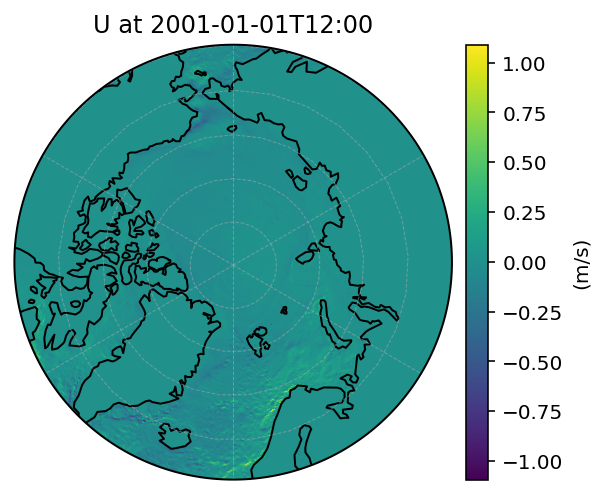

In [7]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [4]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [5]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

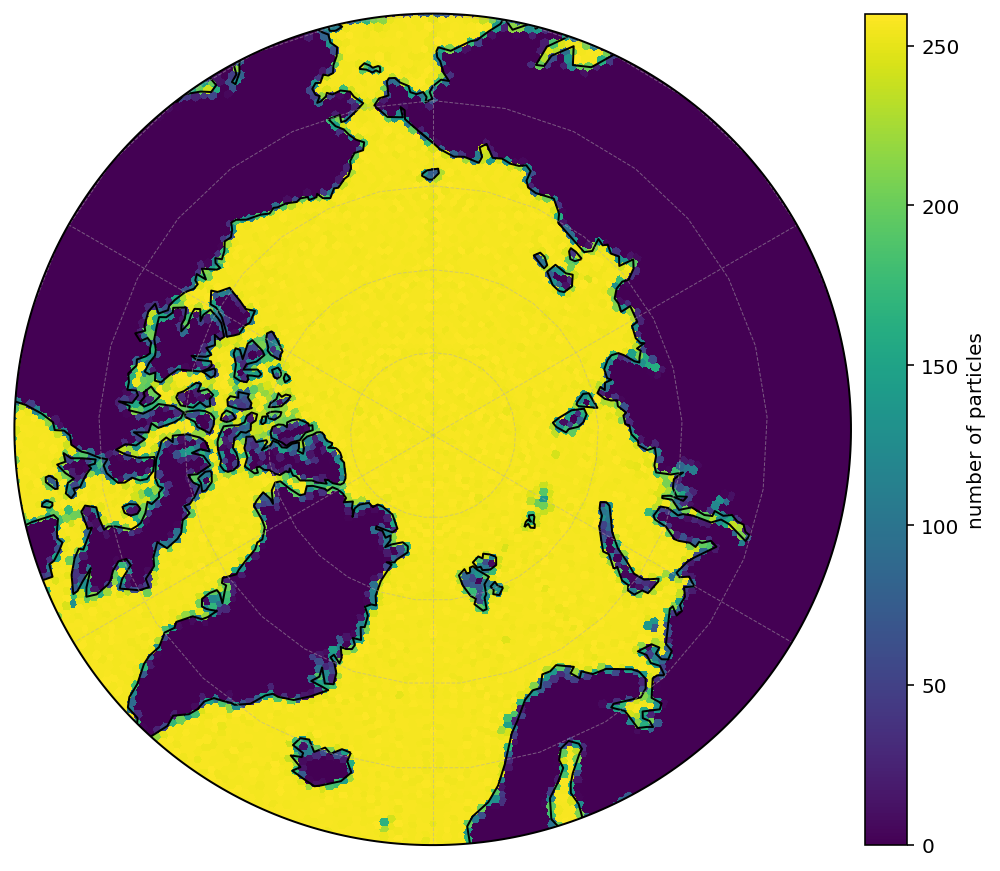

In [20]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "number of particles",
                                             size=(8,8))

In [6]:
runName = "Rcmems_Pico11_S2017-12-1_D90_DT20_ODT24"

In [7]:
transMat_20171201 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(90, 'D'),
                                               mask = myBins.oceanMask)
transMat_20171201.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
transMat_20171201.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

 Determining particle bins. 100%

## March 2018

In [26]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"

In [8]:
transMat_20180301 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(90, 'D'),
                                               mask = myBins.oceanMask)
transMat_20180301.save_counter(matdir + f"masked_counter_{runName}_Cico7")
transMat_20180301.save_network(netdir + f"masked_network_{runName}_Cico7.net")

 Determining particle bins. 100%

In [27]:
transMat_20180301 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [32]:
comName = runName + "_Cico7_subD30_mt2"

In [33]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8023344518411846
Global Mixing Parameter 0.32470413701587175


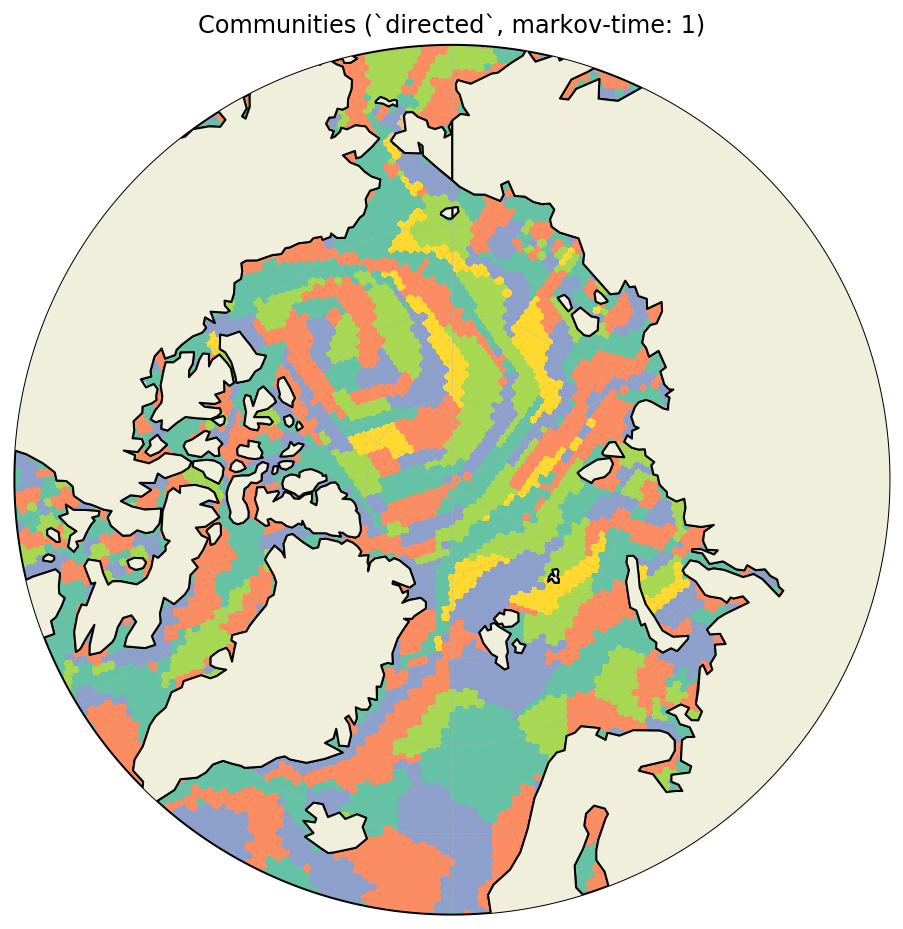

In [34]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (`directed`, markov-time: 1)"
                                            )

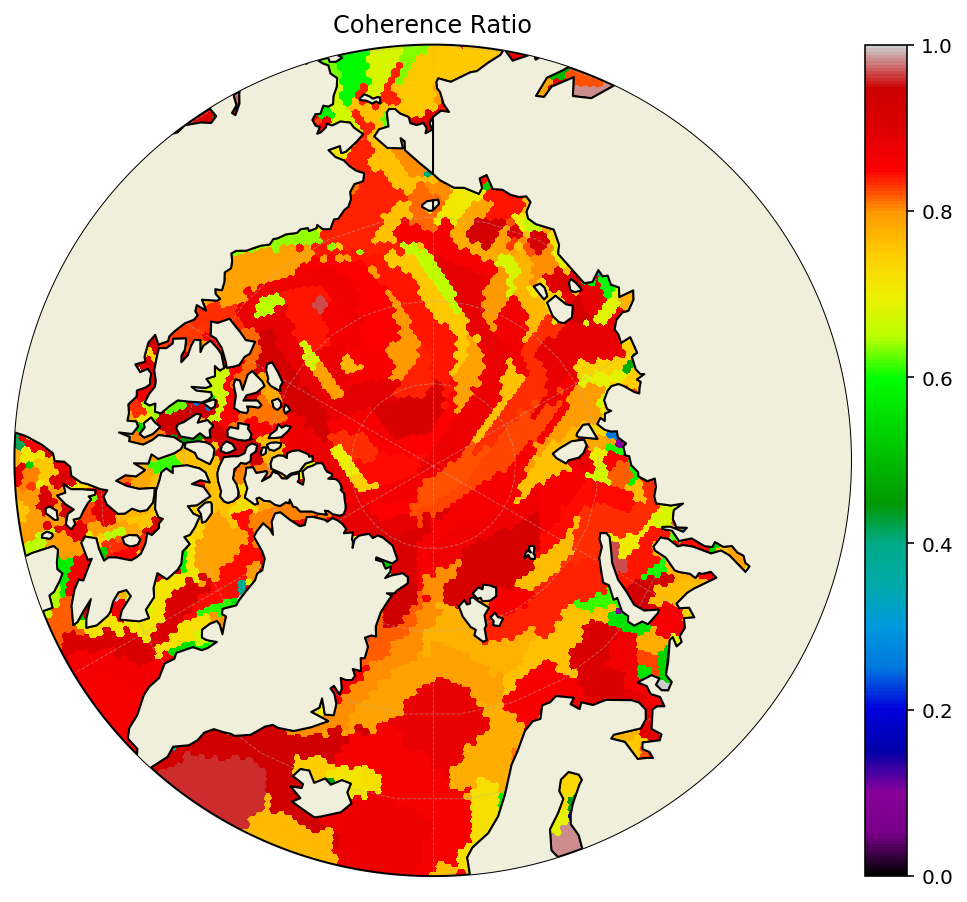

In [40]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

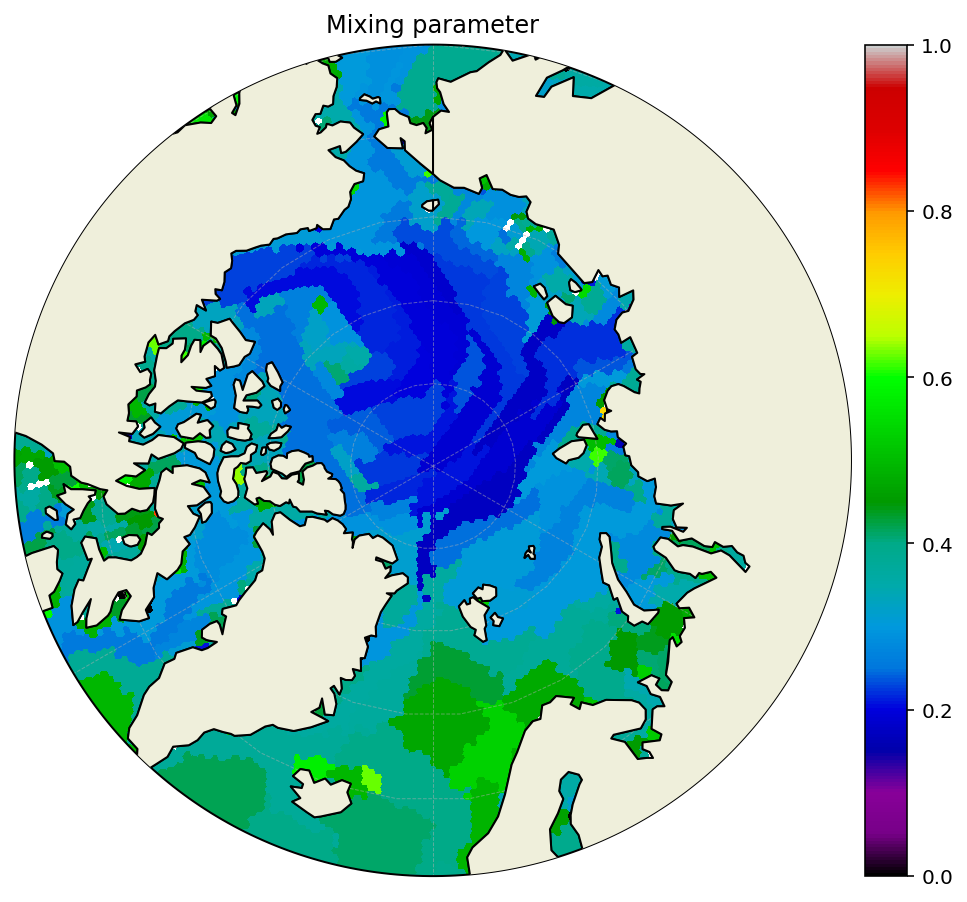

In [41]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"mixing_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Mixing parameter"
                                            )

# Boundary current transitions

In [104]:
def transitionProbabilityPoint(lon, lat):
    pointIndex = np.searchsorted(myBins.bindex[myBins.oceanMask], myBins.pointToIdx(lon, lat))
    pointData = transMat_20180301.data[pointIndex][0]
    dataInBins = np.full(myBins.bindex.shape, np.nan)
    dataInBins[myBins.bindex[myBins.oceanMask]] = pointData
    dataInBins = np.where(dataInBins==0, np.nan, dataInBins)
    fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                                 myBins.svTriLats, 
                                                 myBins.svSimplices[myBins.svDomainMask], 
                                                 dataInBins[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                                lonRange = (-50, 30),
                                                latRange = (60, 90),
                                                land = True,
                                                size = (8,8),
                                                cbar = True,
                                                colormap = 'gist_ncar',
                                                polar = False,
                                                wedge = True,
                                                vmin = 0,
                                                vmax = 1,
                                                units = "Transition probability"
                                                )
    ax.scatter([lon], [lat], marker='*', s=50, c='white', transform=ccrs.PlateCarree())
    plt.show()
    return dataInBins

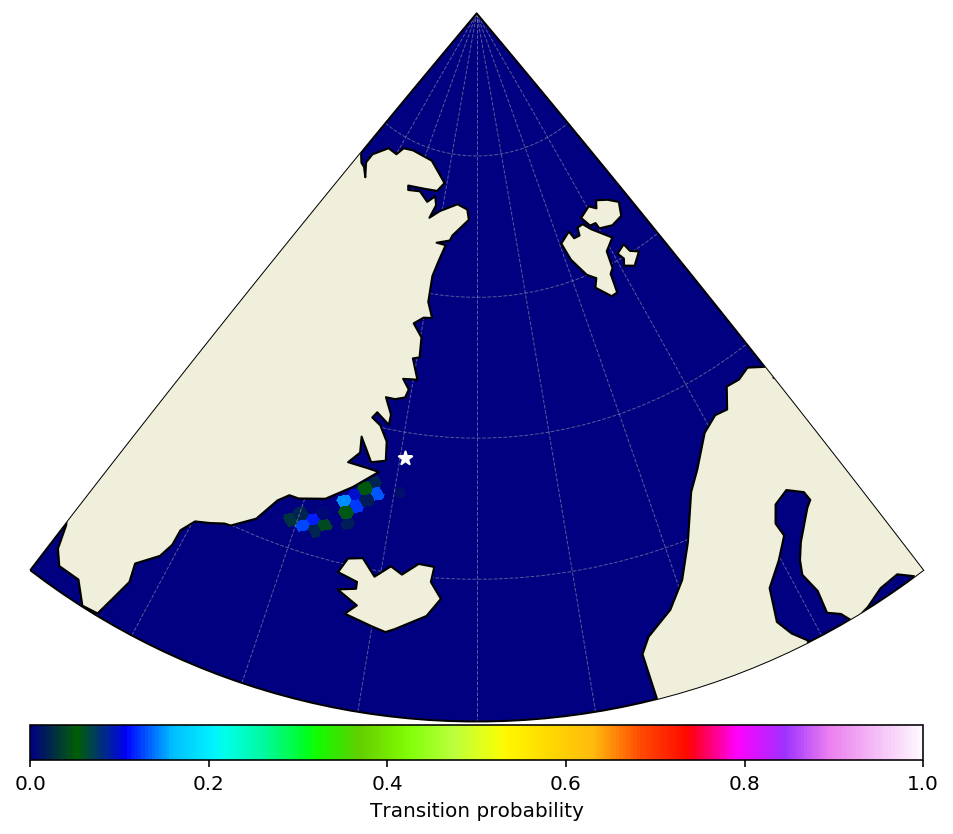

array([nan, nan, nan, ..., nan, nan, nan])

In [105]:
transitionProbabilityPoint(-19.3, 70.9)

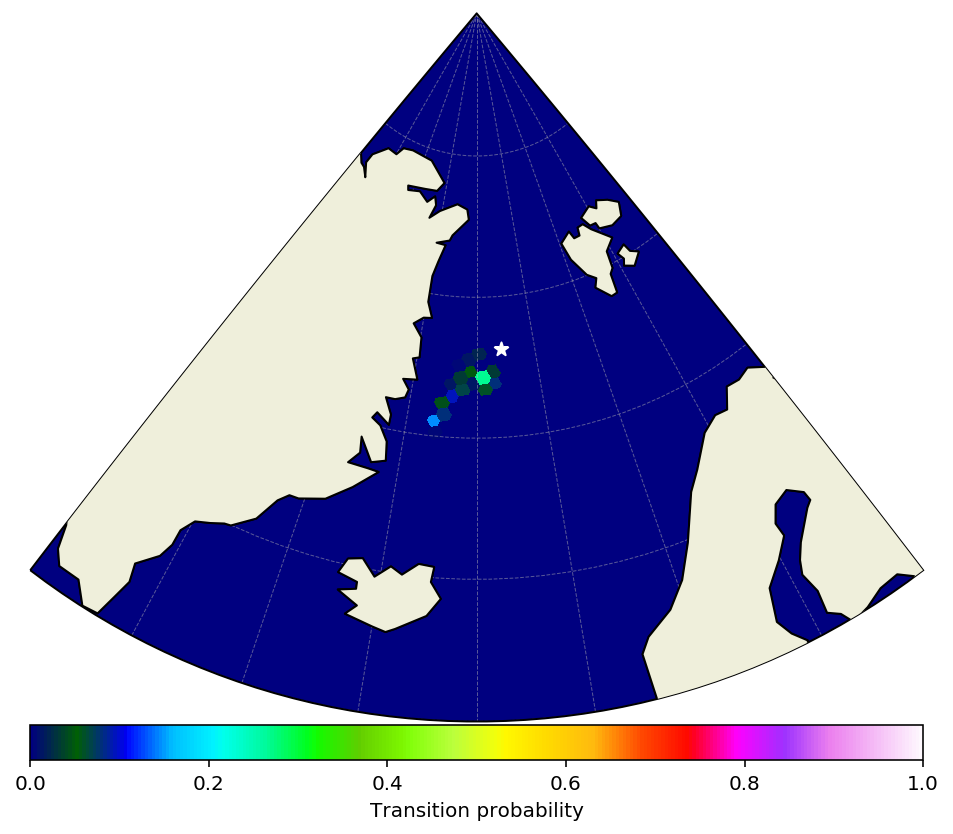

array([nan, nan, nan, ..., nan, nan, nan])

In [106]:
transitionProbabilityPoint(-5.73, 75.76)

# Squared Counter

In [113]:
counterMatSparse = sparse.load_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")
matSquared = community.transMat(np.square(counterMatSparse.toarray()))


In [115]:
matSquared.save_counter(matdir + f"masked_counter_{runName}_squared_Cico7_subD30")
matSquared.save_network(netdir + f"masked_network_{runName}_squared_Cico7_subD30.net")

In [116]:
comName = runName + "_Cico7_subD30_squared_mt2"

In [118]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(matSquared);
myBins.calculate_global_coherence()
myBins.calculate_mixing(matSquared);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8228040398647576
Global Mixing Parameter 0.22455869801099307


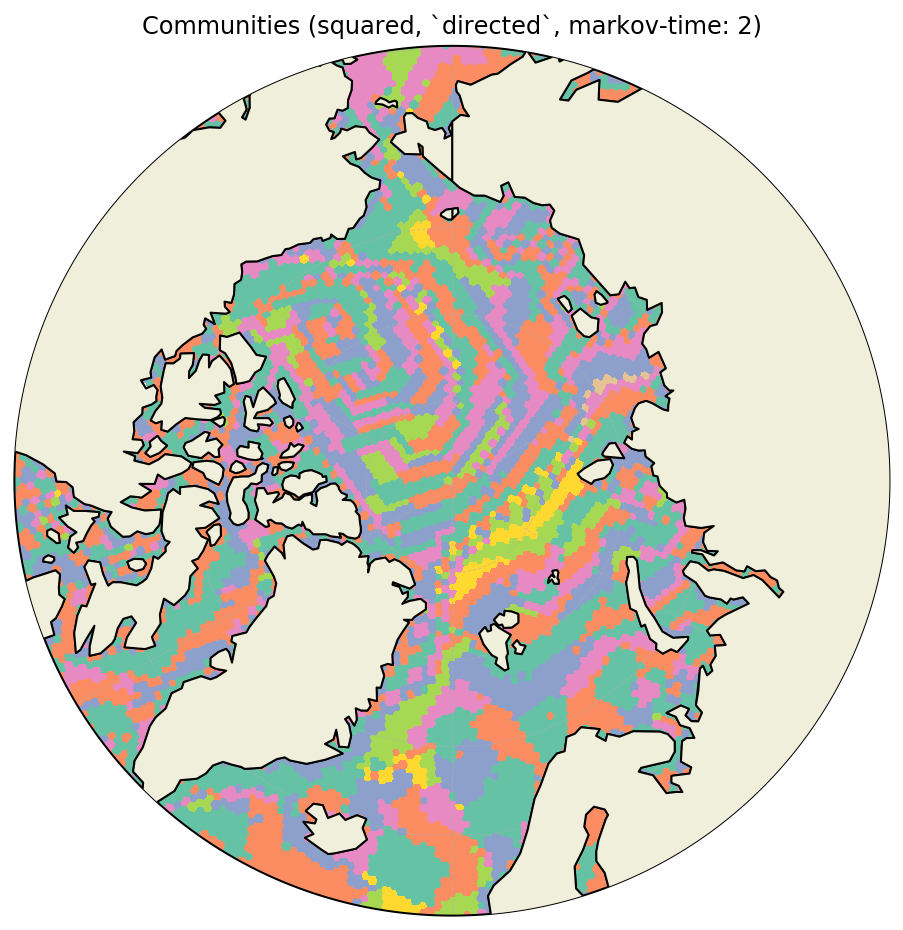

In [119]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (squared, `directed`, markov-time: 2)"
                                            )

# Teleportation probability

In [123]:
comName = runName + "_Cico7_subD30_mt2_p0.01"

In [126]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8014751167045745
Global Mixing Parameter 0.32233594177086217


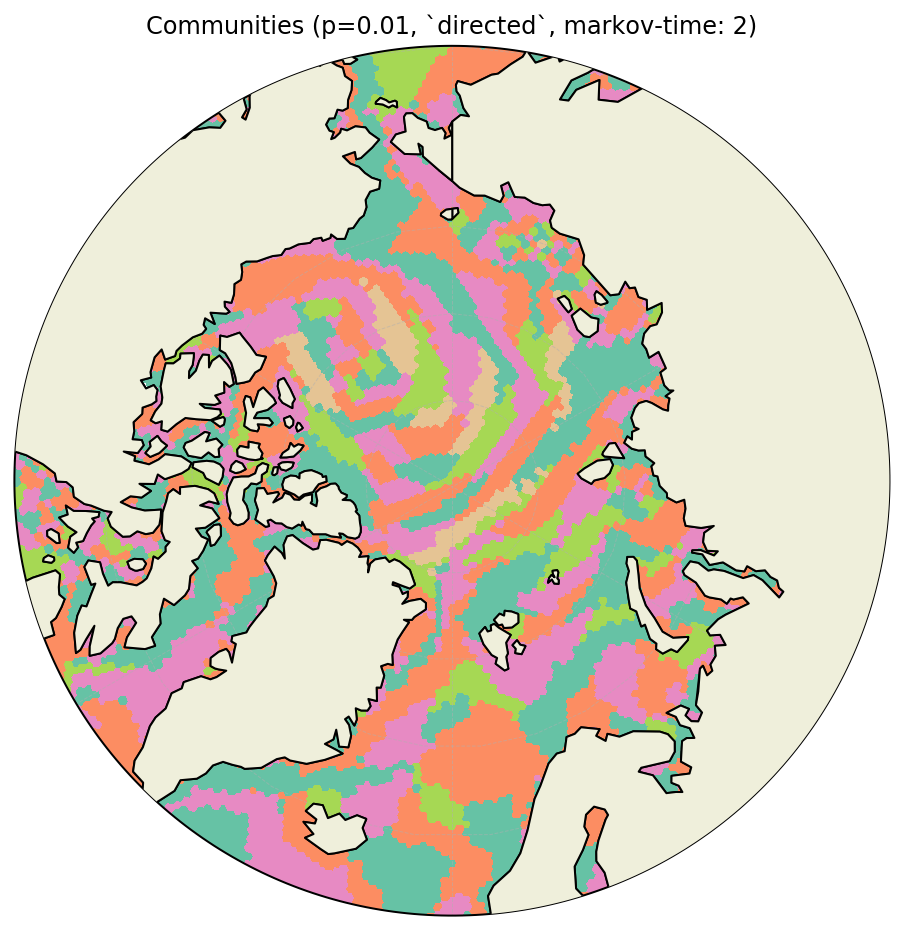

In [127]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (p=0.01, `directed`, markov-time: 2)"
                                            )

In [128]:
comName = runName + "_Cico7_subD30_mt2_p0"

In [129]:
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180301);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180301);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.7726677204146044
Global Mixing Parameter 0.30956726743902147


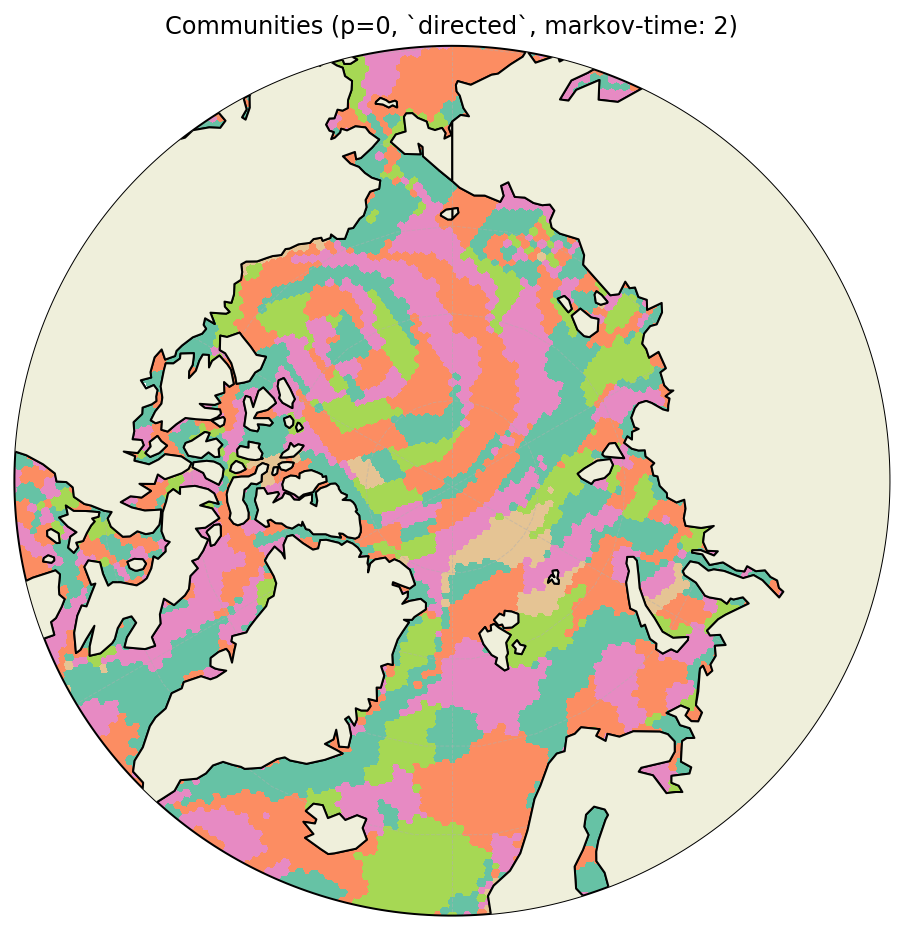

In [131]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (p=0, `directed`, markov-time: 2)"
                                            )

## September 2018

In [8]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"

In [24]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"
transMat_20180901 = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                               myBins, 
                                               timedelta64 = np.timedelta64(30, 'D'),
                                               mask = myBins.oceanMask)
transMat_20180901.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
transMat_20180901.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

 Determining particle bins. 100%

In [12]:
transMat_20180901 = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7_subD30.npz")

In [13]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"
comName = runName + "_Cico7_subD30_mt2"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180901);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180901);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.8176270644682387
Global Mixing Parameter 0.3595052876861782


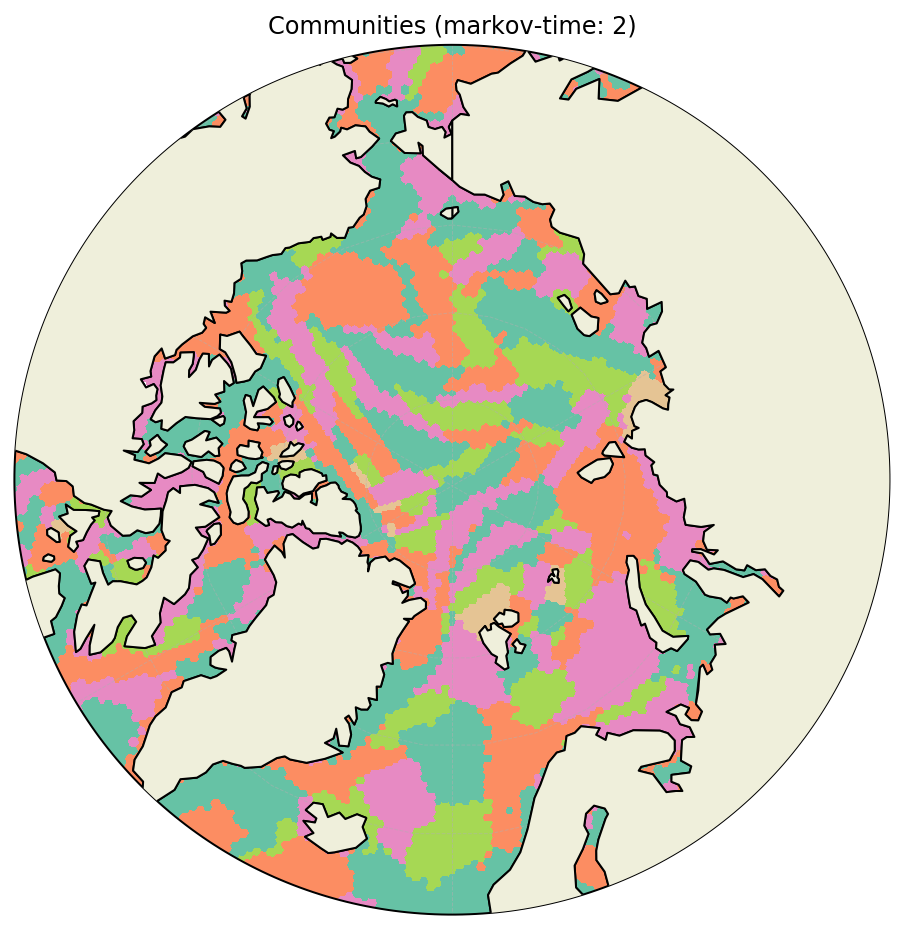

In [32]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{comName}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (markov-time: 2)"
                                            )

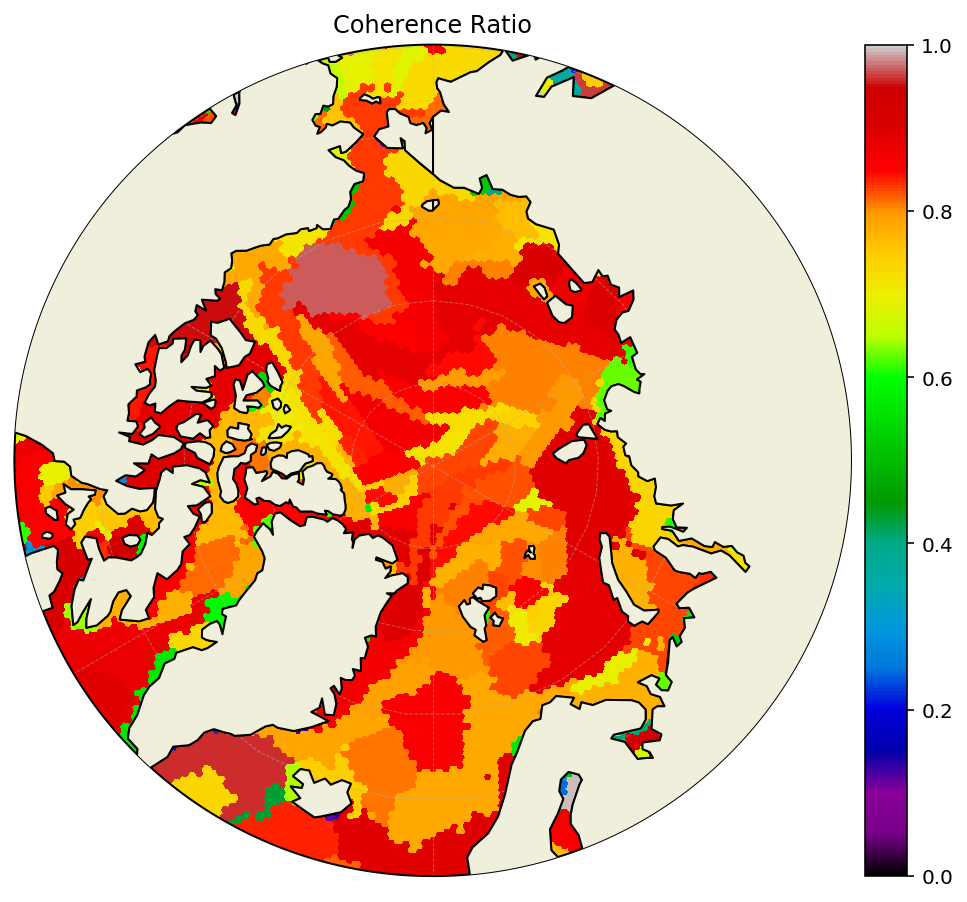

In [43]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.coherenceRatio[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

In [22]:
ice_ds = xr.open_dataset(meanDir + "mercatorglorys12v1_gl12_mean_201809.nc")

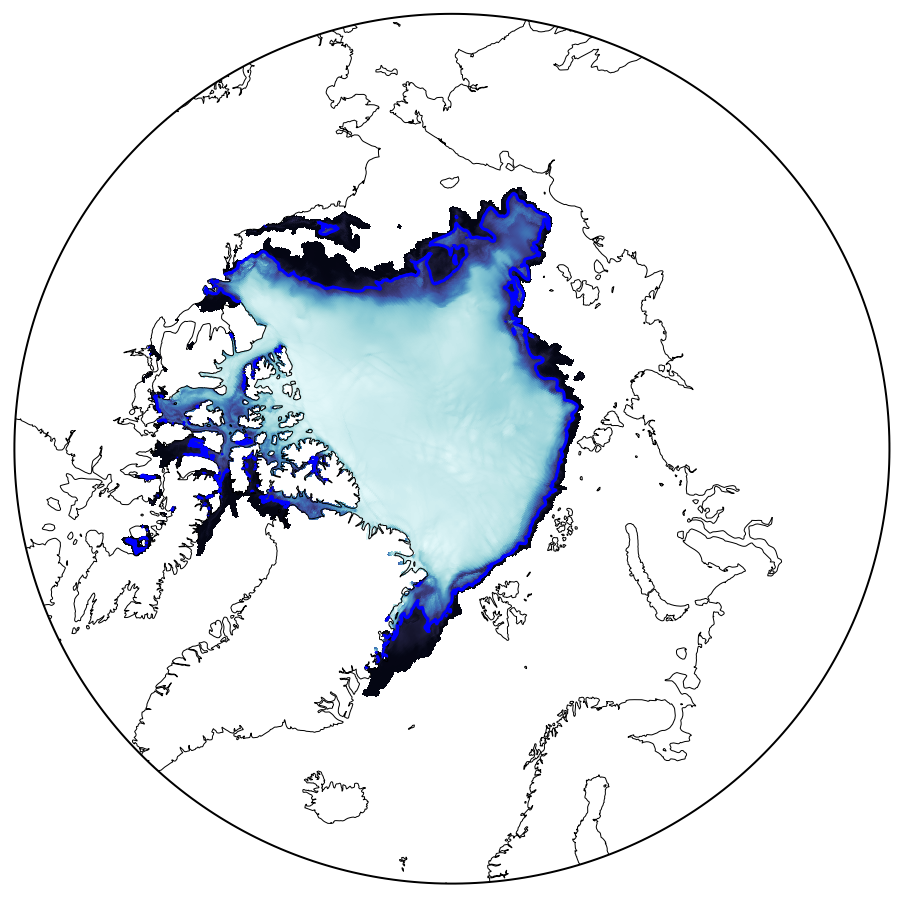

In [25]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent((-180, 180, 60, 90), crs=ccrs.PlateCarree())
circle_clip = plot.set_circular_boundary(ax)
ax.coastlines(resolution='50m', linewidth=0.5)
ax.pcolormesh(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='blue', transform=ccrs.PlateCarree())

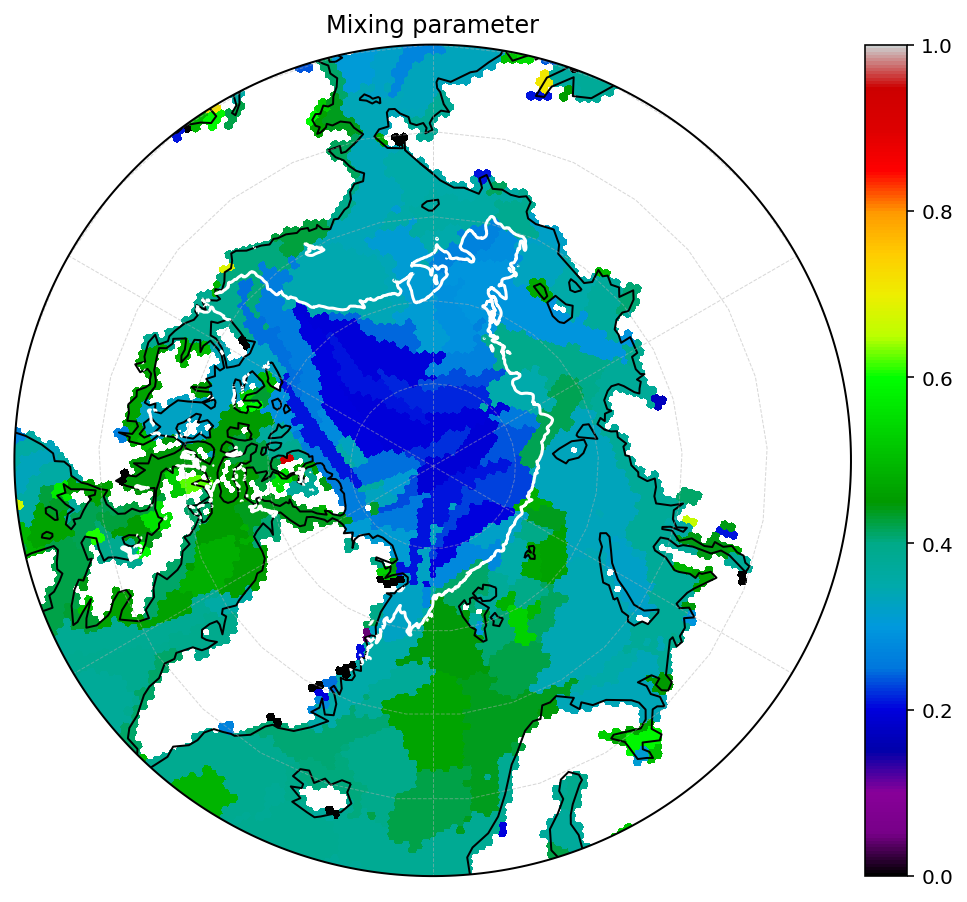

In [46]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.mixing[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = False,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"mixing_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Mixing parameter"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())

In [144]:
ice_ds.siconc[0,1680:, :]

<xarray.DataArray 'siconc' (latitude: 361, longitude: 4320)>
[1559520 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
  * latitude   (latitude) float32 60.0 60.083332 60.166668 ... 89.916664 90.0
    time       datetime64[ns] 2018-09-15T12:00:00
Attributes:
    long_name:      Ice concentration
    standard_name:  sea_ice_area_fraction
    units:          1
    unit_long:      Fraction
    valid_min:      1
    valid_max:      29030
    cell_methods:   area: mean where sea_ice

In [32]:
meshlon, meshlat= np.meshgrid(ice_ds.longitude, ice_ds.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
dataVals = np.where(np.isnan(ice_ds.siconc[0,1680:, :].data.flatten()), 0, ice_ds.siconc[0,1680:, :].data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedIce = griddata(dataPoints, dataVals, binPoints, method="nearest")

In [55]:
def pointToIdx(qlon, qlat, hexBins):
    lons = hexBins.lons[hexBins.mask[hexBins.outerMaskLevel]]
    lats = hexBins.lats[hexBins.mask[hexBins.outerMaskLevel]]
    binPoints = np.dstack((lons, lats))[0]
    return griddata(binPoints, hexBins.bindex, np.dstack((qlon, qlat))[0], method="nearest")

In [56]:
pointToIdx(0, 85, myBins)

array([3061])

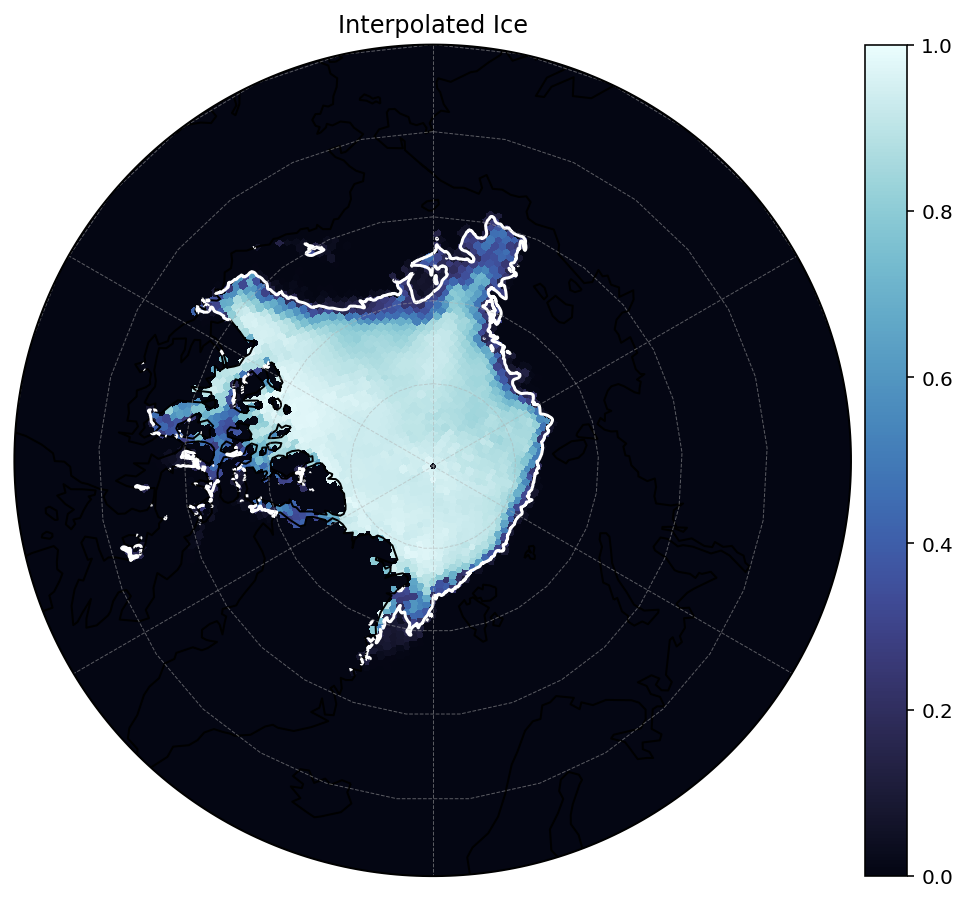

In [49]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             interpolatedIce[myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = False,
                                            colormap = cmocean.cm.ice,
                                            size = (8,8),
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Interpolated Ice"
                                            )
ax.contour(ice_ds.longitude, ice_ds.latitude[1680:], ice_ds.siconc[0, 1680:, :], levels=np.array([0.15]), colors='white', transform=ccrs.PlateCarree())

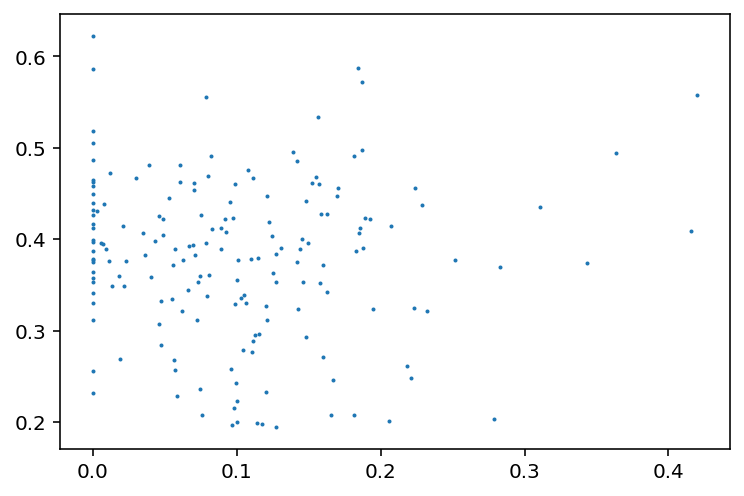

In [50]:
avg_sea_ice_per_community = {}
assert myBins.lons[myMask[3]].shape == myBins.bindex.shape
for community in myBins.communityIdx.keys():
    vals = interpolatedIce[myBins.communityIdx[community]['oceanBindex']]
    avg_sea_ice_per_community[community] = np.mean(vals[~np.isnan(vals)])

communityName, commOccurance = np.unique(myBins.communityID, return_counts=True)
communityStats = pd.DataFrame(commOccurance, index=communityName, columns=["numCells"])
communityStats.drop(-1)
communityStats = communityStats.join(pd.DataFrame.from_dict(avg_sea_ice_per_community, orient='index', columns=['sea_ice']))
communityStats = communityStats.join(pd.DataFrame.from_dict(myBins.mixingDict, orient="index", columns=["mixing"]))
communityStats.replace(to_replace=-1, value=np.NaN, inplace=True)
significantCommunity = communityStats['numCells'] > 4
plt.scatter(communityStats[significantCommunity].dropna()['sea_ice'], 
            communityStats[significantCommunity].dropna()['mixing'], s=1)

In [45]:
communityStats[significantCommunity].dropna().corr()

numCells   sea_ice    mixing
numCells  1.000000  0.082987 -0.066902
sea_ice   0.082987  1.000000 -0.094627
mixing   -0.066902 -0.094627  1.000000

In [41]:
np.sum(communityStats['numCells'] > 20)

94

## 2017: Persistence and sea ice correlations

In [ ]:
for i in range(2010, 2016):
    runName = f"Rcmems_Pico11_S{i}-3-1_D90_DT20_ODT24"
    transMat = community.transMat.from_pset(psetdir + f"pset_{runName}.nc", 
                                                   myBins, 
                                                   timedelta64 = np.timedelta64(30, 'D'),
                                                   mask = myBins.oceanMask)
    transMat.save_counter(matdir + f"masked_counter_{runName}_Cico7_subD30")
    transMat.save_network(netdir + f"masked_network_{runName}_Cico7_subD30.net")

# Boundary at different locations

## Over 65

In [12]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBinsOver65 = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMaskOver65 = community.hexMask(myBinsOver65, -180, 180, 60, 90)
myMaskOver65.growToLevel(4)
myBinsOver65.calculate_voronoi(myMaskOver65, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBinsOver65.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBinsOver65.oceanMask = pickle.load(pickFile)

In [67]:
myBinsOver65.oceanMask = np.logical_and(myBinsOver65.oceanMask, myBinsOver65.lats[myBinsOver65.mask[3]] > 65)
transMaskOver65 = myBinsOver65.lats[myBinsOver65.mask[3]][myBins.oceanMask] > 65

In [38]:
assert transMaskOver65.shape[0] == transMat_20180301.data.shape[0]
transMat_20180301_over65 = copy.deepcopy(transMat_20180301)
transMat_20180301_over65.counter = transMat_20180301_over65.counter[transMaskOver65, :][:, transMaskOver65]
transMat_20180301_over65.sums = transMat_20180301_over65.sums[transMaskOver65, :][:, transMaskOver65]
transMat_20180301_over65.data = transMat_20180301_over65.data[transMaskOver65, :][:, transMaskOver65]

In [35]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
transMat_20180301_over65.save_network(netdir + f"masked_network_over65_{runName}_Cico7_subD30.net")

In [69]:
transMat_20180301_over65_normalized = community.transMat(transMat_20180301.counter[transMaskOver65, :][:, transMaskOver65])
transMat_20180301_over65_normalized.save_network(netdir + f"masked_network_over65_normalized_{runName}_Cico7_subD30.net")

In [41]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver65.load_communities(comdir + f"masked_network_over65_{comName}.clu")
myBinsOver65.find_adjacency();
myBinsOver65.flag_on_boundary();
myBinsOver65.color_communities();
myBinsOver65.calculate_coherence_ratio(transMat_20180301_over65);
myBinsOver65.calculate_global_coherence()
myBinsOver65.calculate_mixing(transMat_20180301_over65);
myBinsOver65.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver65.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver65.globalMixing)

Global Coherence Ratio 0.8184167301979223
Global Mixing Parameter 0.31197459960166496


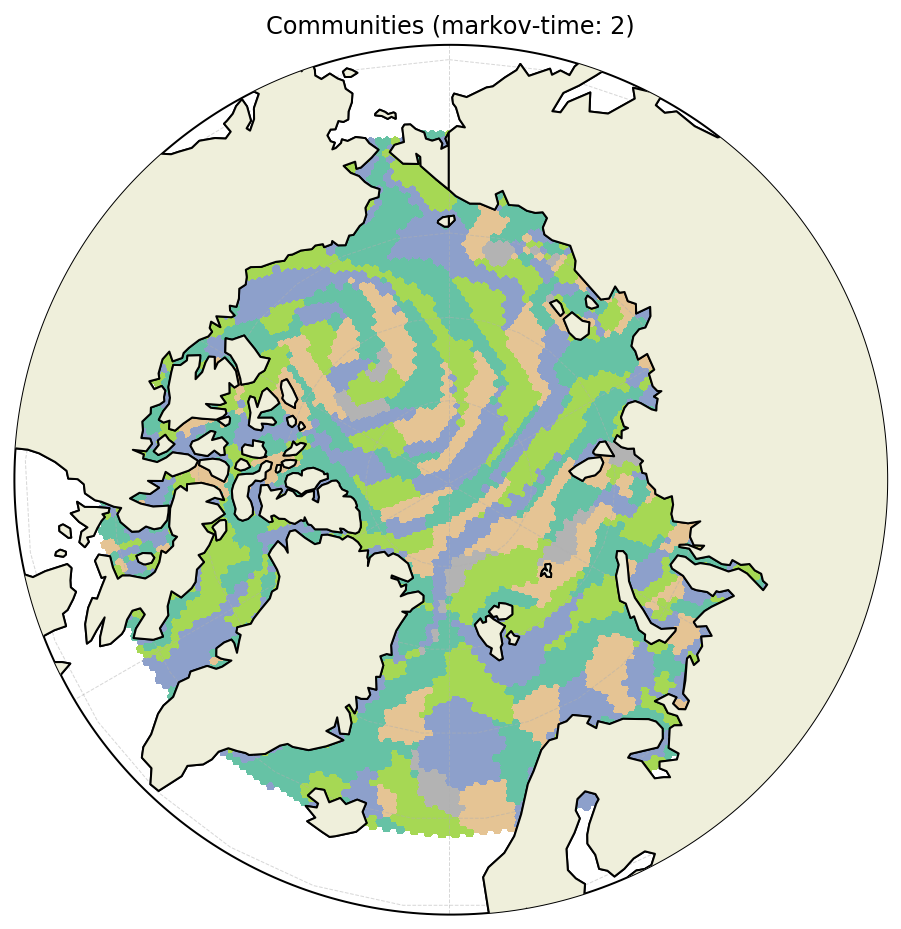

In [60]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver65.svTriLons, 
                                             myBinsOver65.svTriLats, 
                                             myBinsOver65.svSimplices[myBinsOver65.svDomainMask], 
                                             myBinsOver65.colorID[myBinsOver65.hexBindex][myBinsOver65.svSimplices[:,0][myBinsOver65.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over65_killed_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

In [65]:
print("Rows left:", transMat_20180301_over65.data.shape[0])
print("Rows for which 0<sum_of_row<1:", np.sum(np.logical_and(np.sum(transMat_20180301_over65.data, axis=1) < 1, np.sum(transMat_20180301_over65.data, axis=1) > 0)))

Rows left: 5385
Rows for which 0<sum_of_row<1: 734


In [71]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver65.load_communities(comdir + f"masked_network_over65_normalized_{comName}.clu")
myBinsOver65.find_adjacency();
myBinsOver65.flag_on_boundary();
myBinsOver65.color_communities();
myBinsOver65.calculate_coherence_ratio(transMat_20180301_over65);
myBinsOver65.calculate_global_coherence()
myBinsOver65.calculate_mixing(transMat_20180301_over65);
myBinsOver65.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver65.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver65.globalMixing)

Global Coherence Ratio 0.8200848398958739
Global Mixing Parameter 0.3106291967307364


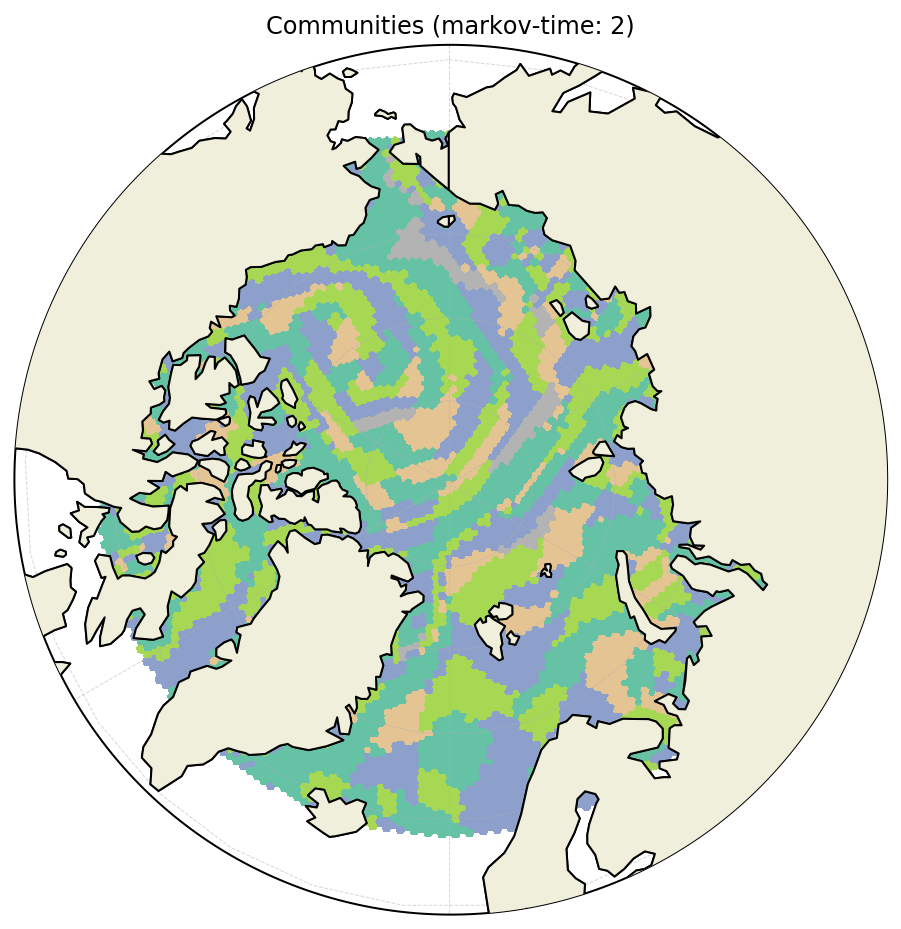

In [72]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver65.svTriLons, 
                                             myBinsOver65.svTriLats, 
                                             myBinsOver65.svSimplices[myBinsOver65.svDomainMask], 
                                             myBinsOver65.colorID[myBinsOver65.hexBindex][myBinsOver65.svSimplices[:,0][myBinsOver65.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over65_normalized_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

## Over 70

In [43]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBinsOver70 = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMaskOver70 = community.hexMask(myBinsOver70, -180, 180, 60, 90)
myMaskOver70.growToLevel(4)
myBinsOver70.calculate_voronoi(myMaskOver70, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBinsOver70.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBinsOver70.oceanMask = pickle.load(pickFile)

In [85]:
myBinsOver70.oceanMask = np.logical_and(myBinsOver70.oceanMask, myBinsOver70.lats[myBinsOver70.mask[3]] > 70)
transMat_20180301_over70_killed = myBinsOver70.lats[myBinsOver70.mask[3]][myBins.oceanMask] > 70

In [86]:
assert transMaskOver70.shape[0] == transMat_20180301.data.shape[0]
transMat_20180301_over70_killed = copy.deepcopy(transMat_20180301)
transMat_20180301_over70_killed.counter = transMat_20180301_over70_killed.counter[transMaskOver70, :][:, transMaskOver70]
transMat_20180301_over70_killed.sums = transMat_20180301_over70_killed.sums[transMaskOver70, :][:, transMaskOver70]
transMat_20180301_over70_killed.data = transMat_20180301_over70_killed.data[transMaskOver70, :][:, transMaskOver70]

In [87]:
print("Rows left:", transMat_20180301_over70.data.shape[0])
print("Rows for which 0<sum_of_row<1:", np.sum(np.logical_and(np.sum(transMat_20180301_over70_killed.data, axis=1) < 1, np.sum(transMat_20180301_over70_killed.data, axis=1) > 0)))

Rows left: 4344
Rows for which 0<sum_of_row<1: 653


In [46]:
runName = "Rcmems_Pico11_S2018-3-1_D90_DT20_ODT24"
transMat_20180301_over70_killed.save_network(netdir + f"masked_network_over70_{runName}_Cico7_subD30.net")

In [70]:
transMat_20180301_over70_normalized = community.transMat(transMat_20180301.counter[transMaskOver70, :][:, transMaskOver70])
transMat_20180301_over70_normalized.save_network(netdir + f"masked_network_over70_normalized_{runName}_Cico7_subD30.net")

In [88]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver70.load_communities(comdir + f"masked_network_over70_killed_{comName}.clu")
myBinsOver70.find_adjacency();
myBinsOver70.flag_on_boundary();
myBinsOver70.color_communities();
myBinsOver70.calculate_coherence_ratio(transMat_20180301_over70_killed);
myBinsOver70.calculate_global_coherence()
myBinsOver70.calculate_mixing(transMat_20180301_over70_killed);
myBinsOver70.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver70.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver70.globalMixing)

Global Coherence Ratio 0.8249333846866814
Global Mixing Parameter 0.2935293978947637


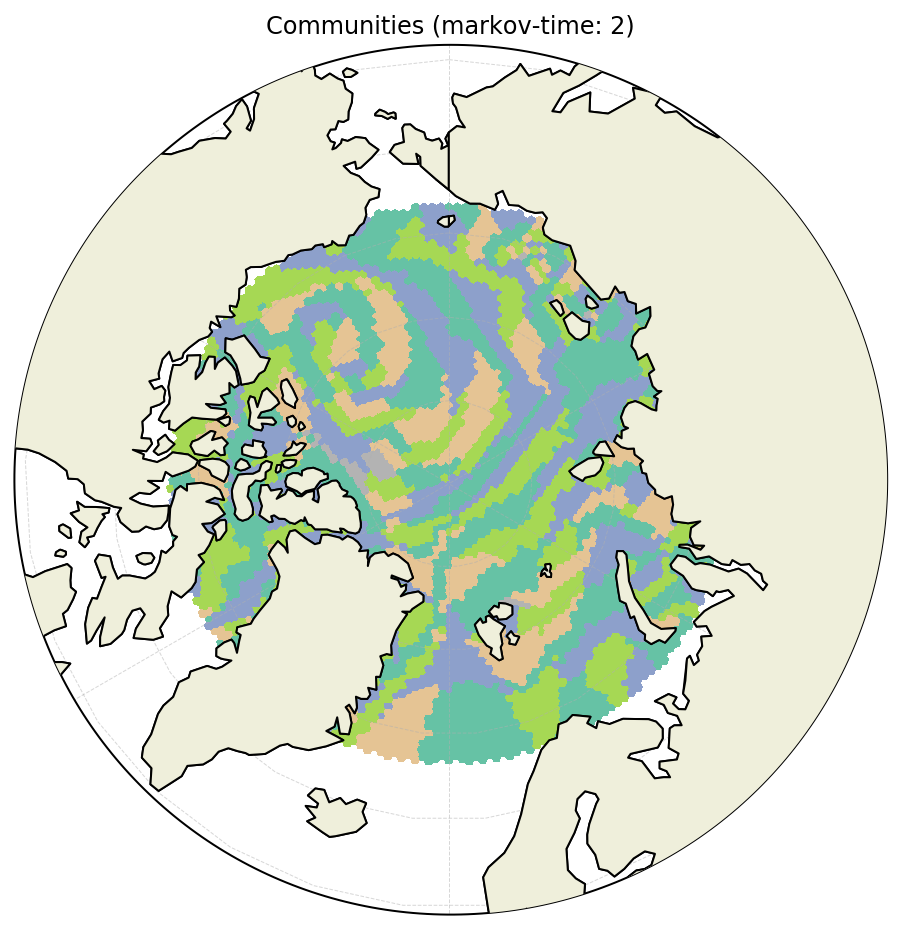

In [61]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.colorID[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over70_killed_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

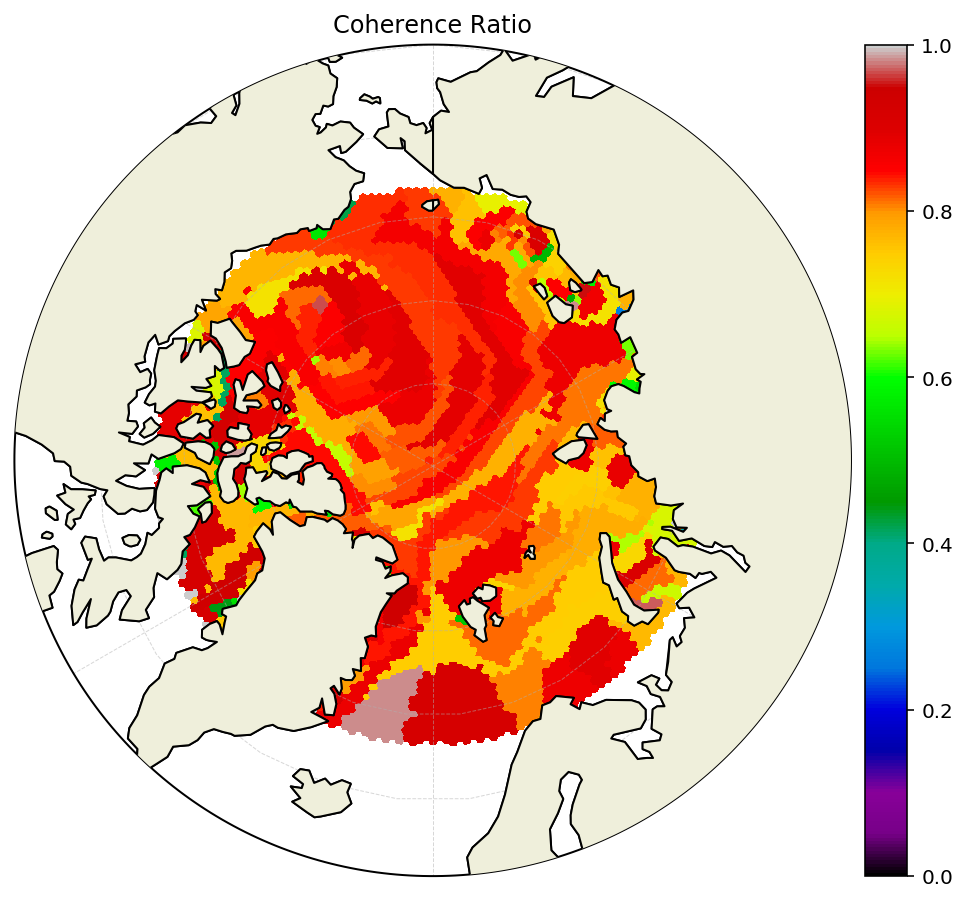

In [89]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.coherenceRatio[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_over70_killed_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )

In [91]:
comName = runName + "_Cico7_subD30_mt2"
myBinsOver70.load_communities(comdir + f"masked_network_over70_normalized_{comName}.clu")
myBinsOver70.find_adjacency();
myBinsOver70.flag_on_boundary();
myBinsOver70.color_communities();
myBinsOver70.calculate_coherence_ratio(transMat_20180301_over70_normalized);
myBinsOver70.calculate_global_coherence()
myBinsOver70.calculate_mixing(transMat_20180301_over70_normalized);
myBinsOver70.calculate_global_mixing()
print("Global Coherence Ratio", myBinsOver70.globalCoherenceRatio)
print("Global Mixing Parameter", myBinsOver70.globalMixing)

Global Coherence Ratio 0.8181736555476736
Global Mixing Parameter 0.2928168940159519


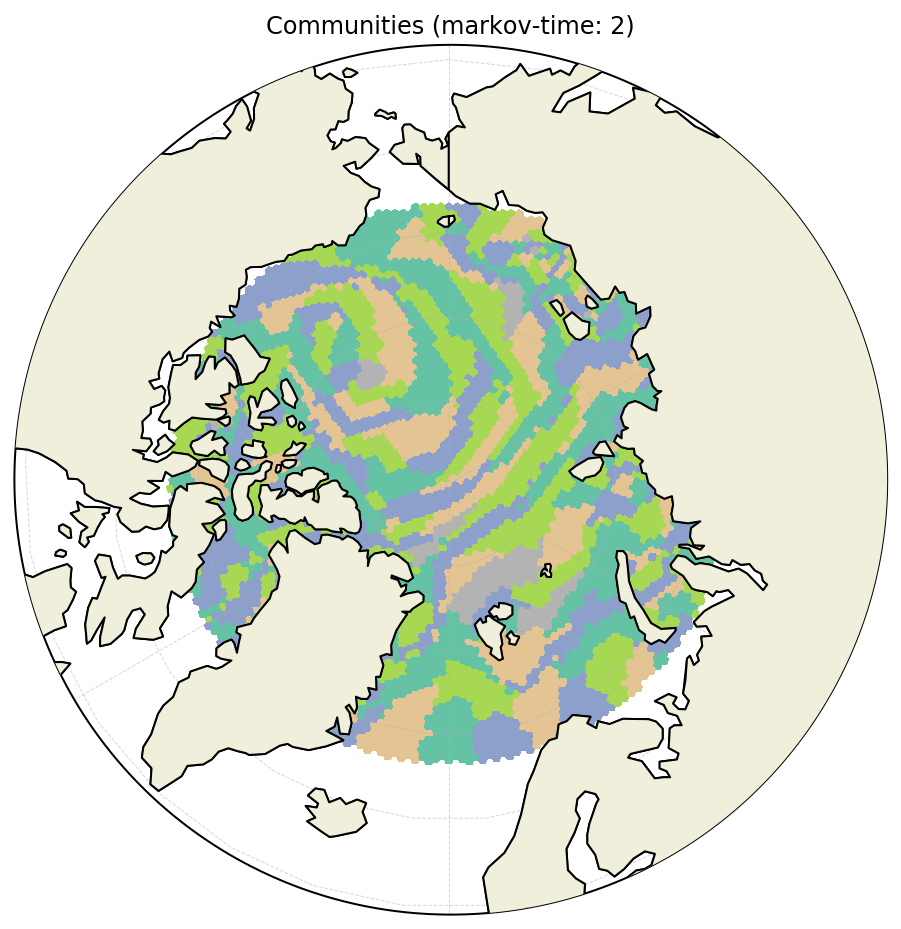

In [74]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.colorID[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            cbar=False,
                                            polar = True,
                                            export = f"communities_over70_normalized_{comName}",
                                            title = "Communities (markov-time: 2)"
                                            )

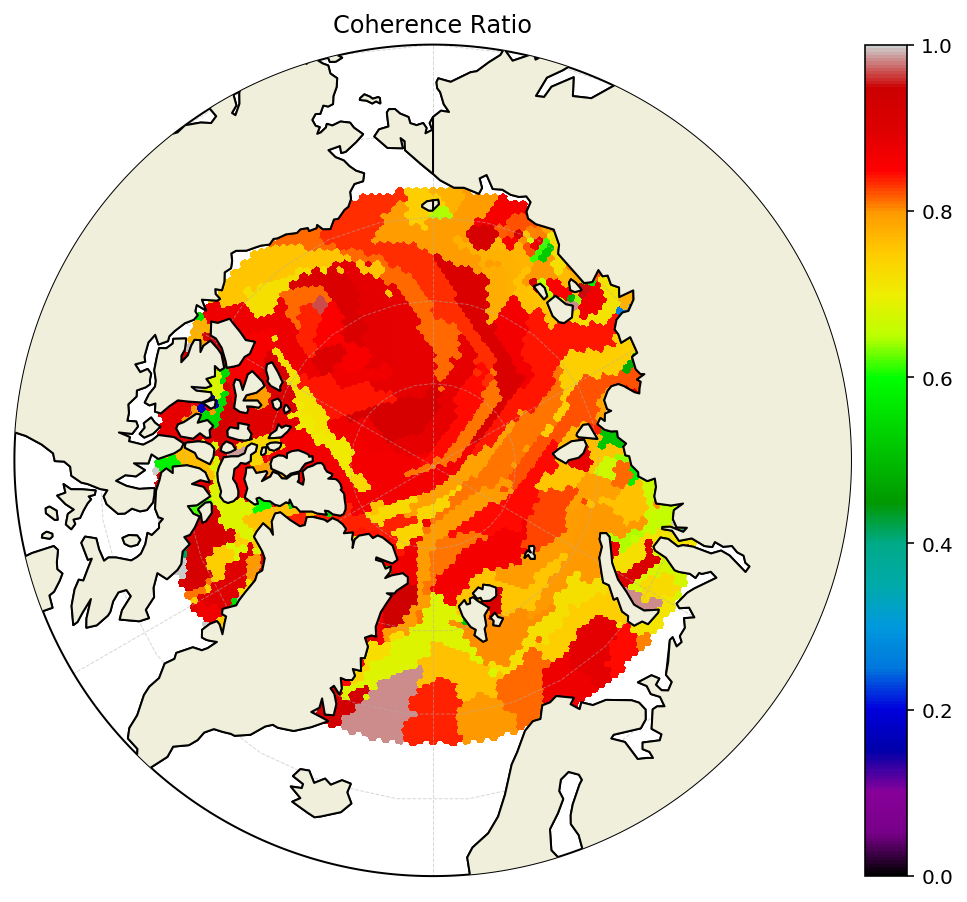

In [92]:
fig, ax = plot.triangular_field_from_dataset(myBinsOver70.svTriLons, 
                                             myBinsOver70.svTriLats, 
                                             myBinsOver70.svSimplices[myBinsOver70.svDomainMask], 
                                             myBinsOver70.coherenceRatio[myBinsOver70.hexBindex][myBinsOver70.svSimplices[:,0][myBinsOver70.svDomainMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            land = True,
                                            colormap = "nipy_spectral",
                                            size = (8,8),
                                            export = f"coherence_over70_normalized_{comName}.png",
                                            cbar = True,
                                            polar = True,
                                            vmin = 0,
                                            vmax = 1,
                                            title = "Coherence Ratio"
                                            )